Imports

In [330]:

''' Standard Imports '''
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

''' SNS Imports '''
from NetworkGeneration import STDPNetworkGenerator
from NetworkGeneration_MN import MNNetworkGenerator
from sns_toolbox.renderer import render
from sns_toolbox.neurons import SpikingNeuron
from sns_toolbox.connections import SpikingSynapse

''' MuJoCo Imports '''
import mujoco as mj
import mediapy as media

''' Other Misc Imports '''
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from random import Random, randint

''' Make the plots pretty and slooooooow '''
mpl.rcParams['figure.dpi'] = 600 # 600 is pretty high definition

ISI Code

In [331]:

# Takes spike data string, returns frequency of spikes
def getFreq(data, dt):
    loc = np.where(data == 1)[0]
    freq = []
    for i in range(len(loc)-1):
        freq.append(1 / ((loc[i+1] - loc[i]) * (dt * 0.001)))
    # The first element needs to be removed because this is inner spike, so more spikes than frequencies recorded
    loc = loc[1:] * dt
    return freq, loc

Noise generation for current signals

In [332]:

''' Adds noise to current signals '''
def NoisyAmps(smooth, percent_noise=float):
    percent_noise = percent_noise / 100
    noisy = np.copy(smooth)
    time, motor = smooth.shape
    for mn in range(motor):
        for i in range(time):
            if smooth[i, mn] > 1.0:
                noisy[i, mn] = randint(int((smooth[i, mn] * (1 - percent_noise)) * 10000), int((smooth[i, mn] * (1 + percent_noise)) * 10000)) / 10000
    return noisy

Motor neuron activation code

In [333]:

''' Need to update such that there is a dynamic number of motor neurons '''
def randActivation2(t, pair_freq, indi_freq, num_motors):
    i_IN1 = np.zeros([len(t)])
    i_IN2 = np.zeros([len(t)])
    i_IN3 = np.zeros([len(t)])
    i_IN4 = np.zeros([len(t)])

    # Initilize at 0b00
    pair_act = 0b00
    indi_act1 = 0b00
    indi_act2 = 0b00

    for i in range(len(t)):
        if pair_act & 0b01:
            if indi_act1 & 0b01:
                i_IN1[i] += 1
            if indi_act1 & 0b10:
                i_IN2[i] += 1

        if pair_act & 0b10:
            if indi_act2 & 0b01:
                i_IN3[i] += 1
            if indi_act2 & 0b10:
                i_IN4[i] += 1

        if i % pair_freq == 0:
            pair_act = randint(0, 3)
            
        if i % indi_freq == 0:
            indi_act1 = randint(0, 3)
            indi_act2 = randint(0, 3)
    
    return i_IN1, i_IN2, i_IN3, i_IN4

def randActivation3(t, pair_freq, indi_freq, num_motors):
    interneuron_i = np.zeros(shape=[len(t), num_motors])

    # Inilize at 0b00
    pair_act = 0b00
    indi_act1 = 0b00
    indi_act2 = 0b00

    for i in range(len(t)):
        if pair_act & 0b01:
            if indi_act1 & 0b01:
                interneuron_i[i, 0] += 1
            if indi_act1 & 0b10:
                interneuron_i[i, 1] += 1

        if pair_act & 0b10:
            if indi_act2 & 0b01:
                interneuron_i[i, 2] += 1
            if indi_act2 & 0b10:
                interneuron_i[i, 3] += 1

        if i % pair_freq == 0:
            pair_act = randint(0, 3)
            
        if i % indi_freq == 0:
            indi_act1 = randint(0, 3)
            indi_act2 = randint(0, 3)

    return interneuron_i
    

def manualActivation(t, num_motors, active):
    interneuron_i = np.zeros(shape=[len(t), num_motors])

    if active & 0b0001:
        interneuron_i[:, 0] += 1
    if active & 0b0010:
        interneuron_i[:, 1] += 1
    if active & 0b0100:
        interneuron_i[:, 2] += 1
    if active & 0b1000:
        interneuron_i[:, 3] += 1
    return interneuron_i

Random conductance matrix generator for synaptic connections

In [334]:

def randConnections(pre_num, post_num, seed=None, g_min=1.50, g_max=5.00):
    if seed is not None:
        rng = Random(x=seed)
    else:
        rng = Random()
    '''
    For Conductances
    2.99 is a barely spikes the post when paired.
    g_max is for solo spiking. 
    '''
    g_min = int(g_min * 100) # Convert to int
    g_max = int(g_max * 100) # Convert to int

    # Empty matrix for conductivity parameters
    matrix = np.zeros([pre_num + post_num, pre_num + post_num])

    for pre in range(0, pre_num):
        for post in range(pre_num, pre_num + post_num):
            matrix[post, pre] = (rng.randint(g_min, g_max) / 100)
    
    return matrix

Ia feedback to current conversion

In [335]:

# Base spiking rate of 80Hz (Current corresponding to the spiking rate)
BASERATE = 82 # Hz
BASERATE_CURRENT = 1.09 # Old method. Amount of current to achieve ~82Hz

# Equation relating input current to output spike frequency. Modeled in "Plot_CurrentFrequencyRelation" code
def freq2cur(freq):
    T_fit = 0.00499132 # From equation fit to experimental data for neuron firing rate based on current
    return 1 / (-1*np.exp(-1 / (T_fit * freq)) + 1)

''' Emulates type Ia feedback converting length/velocity data into current to be sent to sensory neuron '''
def vel2cur(length, velocity, current_time):
    percent_noise = 0.001
    # Convert to mm for the equation
    length = length * 1000 
    velocity = velocity * 1000
    current = np.zeros(len(length))

    global BASERATE_CURRENT_NOISY

    if current_time % 10 == 0:
        BASERATE_CURRENT_NOISY = np.zeros(len(length))
        for neuron in range(len(length)):
            BASERATE_CURRENT_NOISY[neuron] = randint(int((BASERATE_CURRENT * (1 - percent_noise)) * 10000), int((BASERATE_CURRENT * (1 + percent_noise)) * 10000)) / 10000

    for neuron in range(len(length)):
        if abs(velocity[neuron]) >= 1:
            # Calculate the current to be sent to the neuron
            # Maintain signs for negatives raised to a power
            velocity_sign = np.sign(velocity[neuron])
            # Prochazka's Equation. Desired spiking frequency
            Ia_Spike_Freq = (velocity_sign * 4.3 * abs(velocity[neuron])**0.6) + (2 * length[neuron]) + BASERATE
            # print('Ia Spike Frequency: ' + str(Ia_Spike_Freq))
            
            # Calculate the current that alligns to the desired spike frequency
            current[neuron] = freq2cur(Ia_Spike_Freq)
            if current[neuron] < (BASERATE_CURRENT * (1 - 0.025)):
                current[neuron] = BASERATE_CURRENT_NOISY[neuron]
        else:
            current[neuron] = BASERATE_CURRENT_NOISY[neuron]

        

        # Ensure it remains above the baserate
        # if current[neuron] <= BASERATE_CURRENT:
        #     # current[neuron] = BASERATE_CURRENT
        #     current[neuron] = BASERATE_CURRENT_NOISY[neuron]
    return current

Import XML file of test leg


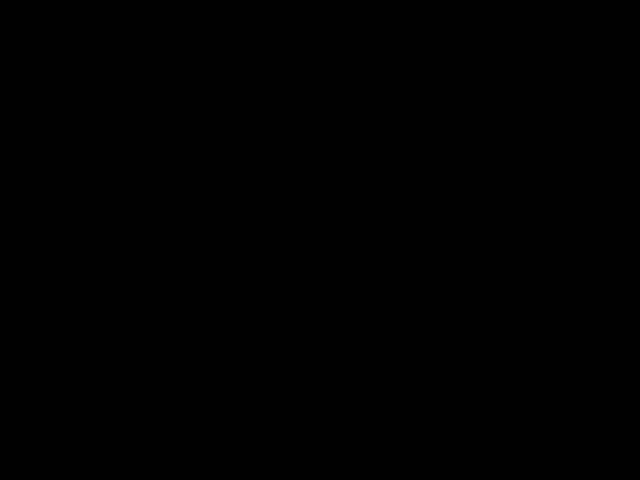

In [336]:

''' Load MuJoCo File '''
# Load model
mjmodel = mj.MjModel.from_xml_path('C:/Users/markpup/SNNCode/MJ_Leg_Smaller.xml')
mjdata = mj.MjData(mjmodel)
# Create MuJoCo renderer
renderer = mj.Renderer(mjmodel)

# Camera options for the fun of it
mj_camera = ['fixed', 'Angle2', 'Angle3', 'Angle4', 'Angle5', 'Angle6']
active_camera = 5

# Show image of XML file for reference
mj.mj_forward(mjmodel, mjdata)
renderer.update_scene(mjdata, camera=mj_camera[0])
media.show_image(renderer.render())
renderer.close() # Needed to prevent crashing?

Time parameters for neural networks and MuJuCo simulations

In [337]:

''' SNS Parameters '''
sns_dt = 0.1 # ms NOTE: This aligns to the XML file. You cannot change this without changing the definition in the xml file!
sns_tmax = 10000 # ms
sns_t = np.arange(0, sns_tmax, sns_dt)

''' MuJoCo Parameters '''
mj_dt = sns_dt / 1000 # Converts to seconds. essentially 0.0001 s
mj_tmax = sns_tmax / 1000 # Converts to seconds. essentially 10.000 s
mj_t = np.arange(0, mj_tmax, mj_dt)

framerate = 60 # fps for movie capture

STDP Neural Network Creation and Parameter Definition

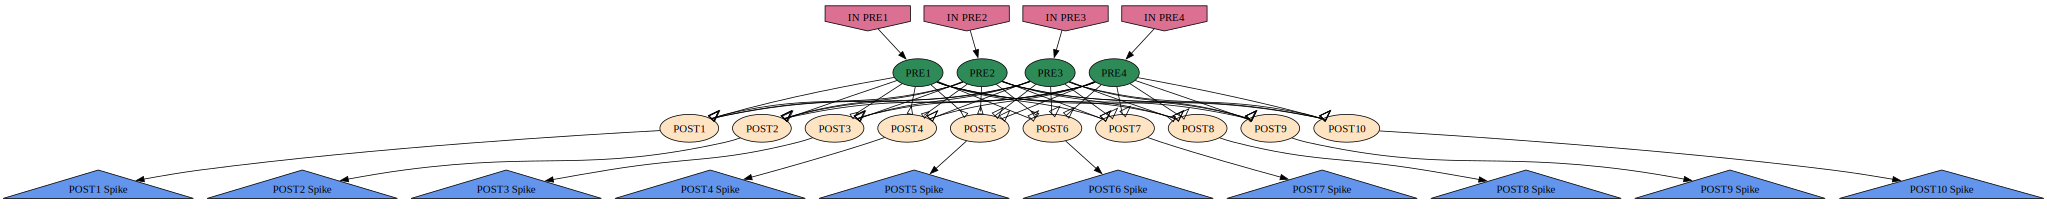

In [338]:

# Define pre- and postsynaptic neurons
pre_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)
post_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)
# Define Synapse
synapse = SpikingSynapse(
    reversal_potential=2.0,
    max_conductance=3.0
)

# Parameters for the number of neurons
STDP_PRE_NUM = 4
STDP_POST_NUM = 10

# Send to function to generate the network
net = STDPNetworkGenerator(presynaptic_type=pre_neuron, postsynaptic_type=post_neuron, presynaptic_neurons=STDP_PRE_NUM, postsynaptic_neurons=STDP_POST_NUM, synapse_type=synapse)

# Network learning variables
# LTP
ltp_a = 0.010 #0.016
ltp_t = 0.5
# LTD
ltd_a = 0.012
ltd_t = 2.5
max_condutance = 4.0

# Display the network
render(net)

Motor neuron network creation

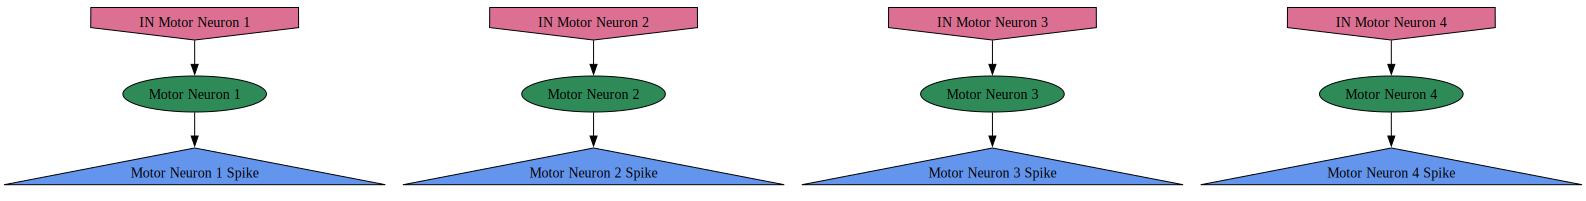

In [339]:

# Define spiking motor neuron
motor_neuron = SpikingNeuron(
    threshold_proportionality_constant=0.0,
    threshold_initial_value=1.0
)

# Parameter for number of motor neurons (should like up with number of presynaptic neurons)
MOTOR_NEURON_NUM = STDP_PRE_NUM

# Send to function to generate the network as desired
net_motor = MNNetworkGenerator(neuron_type=motor_neuron, motor_neurons=MOTOR_NEURON_NUM)

# Display the network
render(net_motor)

Compile motor neuron network and learning neural network

In [340]:

# Compile learning network
sns_stdp_network = net.compile(dt=sns_dt, backend='numpy', debug=False,
                STDP_PRE=STDP_PRE_NUM, STDP_POST=STDP_POST_NUM,
                STDP_LTP_A=ltp_a, STDP_LTP_T=ltp_t, STDP_LTD_A=ltd_a, STDP_LTD_T=ltd_t,
                MAX_CONDUCTIVITY=max_condutance)


# Compile motor neuron network
sns_mn_network = net_motor.compile(dt=sns_dt, backend='numpy_standard', debug=False)

Randomize initial synaptic connections

In [341]:

RANDOMIZED_CONDUCTIVITY = randConnections(STDP_PRE_NUM, STDP_POST_NUM, g_max=max_condutance)

# Print statements if you want to check 
# print(sns_stdp_network.__dict__.get('g_max_spike'))
# print(sns_stdp_network.g_increment)
# print(sns_stdp_network.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM])
initial_conductance = np.copy(RANDOMIZED_CONDUCTIVITY[STDP_PRE_NUM:, 0:STDP_PRE_NUM])
# print(sns_stdp_network.__dict__.get('pre_spike_diff'))
# print(sns_stdp_network.__dict__.get('post_spike_diff'))
RANDOMIZED_CONDUCTIVITY[4, 0:4] = [1, 1.7, 1.5, 2.1]
RANDOMIZED_CONDUCTIVITY[5, 0:4] = [3.5, 3.6, 3.1, 3.7]

print(RANDOMIZED_CONDUCTIVITY)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.   1.7  1.5  2.1  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.5  3.6  3.1  3.7  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.26 3.99 2.68 2.08 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.72 2.2  3.17 2.52 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.72 3.18 2.59 3.57 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.52 3.83 3.66 2.92 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.9  2.57 3.14 1.77 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [3.85 3.09 3.94 1.77 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [2.47 3.75 2.23 3.82 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.82 2.37 2.91 3.99 0.   0.   0.   0.   0.   0.  

Initialize MuJoCo parameters and stored values

In [342]:

# Number of muscles in MuJoCo model
MJ_MUSCLE_NUM = MOTOR_NEURON_NUM

''' Motor Neuron '''
# Activation sent to SNS
mn_activation_current = np.zeros(shape=(len(sns_t), net_motor.get_num_inputs_actual()))

# Motor neuron output from SNS 
mn_data = np.zeros(shape=(len(sns_t), net_motor.get_num_outputs_actual()))

''' Sensor feedback from MuJoCo '''
mj_length_data = np.zeros(shape=[len(mj_t), MJ_MUSCLE_NUM])
mj_velocity_data = np.zeros(shape=[len(mj_t), MJ_MUSCLE_NUM])

# Resting length recording
mj_length_resting = mjdata.sensordata[0:MJ_MUSCLE_NUM].copy()

''' STDP Network Parameters '''
# Current to Inject into Ia Feedback Neurons == INTO SNS
stdp_activation_current = np.zeros(shape=(len(sns_t), net.get_num_inputs_actual()))

# Learning network output data collection == OUTPUT of SNS
stdp_data = np.zeros([len(sns_t), net.get_num_outputs_actual()])

''' Assigning injected current to motor neurons '''
mn_activation = randActivation3(sns_t, 20000, 4000, num_motors=MJ_MUSCLE_NUM)
# mn_activation = manualActivation(sns_t, num_motors=MJ_MUSCLE_NUM, active=0b0011)

activation_level = 1.02 # From Paper: Hoffer Cat Hindlimb Motoneurons

mn_activation_current[:, 0] = mn_activation[:, 0] * activation_level
mn_activation_current[:, 1] = mn_activation[:, 1] * activation_level
mn_activation_current[:, 2] = mn_activation[:, 2] * activation_level
mn_activation_current[:, 3] = mn_activation[:, 3] * activation_level

mn_activation_current = NoisyAmps(mn_activation_current, 5)

MAX_MUSCLE_POWER = 25

# Tracking changes in conductance over the simulation
g_track = np.zeros(shape=[len(sns_t), STDP_POST_NUM, STDP_PRE_NUM])

# Percent noise for Ia afferent neurons
IA_BASELINE_NOISE = 0.01

Set up MuJoCo renderer and frames

In [343]:

# Set up variable to capture frames
frames = []
# Reset Simulation
mj.mj_resetData(mjmodel, mjdata)
# Restart Renderer
renderer = mj.Renderer(mjmodel)

Run "The Simulation"

In [344]:

for i in range(len(sns_t)):

    ''' Motor Neuron SNS '''
    mn_data[i,:] = sns_mn_network(mn_activation_current[i,:])

    ''' Spiking Motor Neuron === Muscle Activation '''
    if sum(sns_mn_network.__dict__.get('spikes')) != 0:
        mn_spike = sns_mn_network.__dict__.get('spikes')

        # If a spike occured for a specific motor, activate it for a timestep
        for muscle in range(MJ_MUSCLE_NUM):
            if mn_spike[muscle] != 0:
                mjdata.act[muscle] = MAX_MUSCLE_POWER
            else:
                mjdata.act[muscle] = 0.0
    else:
        mjdata.act[:] = 0.0

    ''' Advance MuJoCo Simulation '''
    mj.mj_step(mjmodel, mjdata)

    # Capture frame data if it corresponds to framerate demands
    # if len(frames) < mjdata.time*framerate:
    #     if len(frames) % 120 == 0:
    #         active_camera += 1
    #         if active_camera >= len(mj_camera):
    #             active_camera = 0
    #     renderer.update_scene(mjdata, camera=mj_camera[0])
    #     pixels = renderer.render().copy()
    #     frames.append(pixels)
    

    ''' Record MuJoCo Sensor Outputs '''
    mj_length_data[i] = mjdata.sensordata[0:MJ_MUSCLE_NUM]
    mj_velocity_data[i] = mjdata.sensordata[MJ_MUSCLE_NUM:]

    # Subtract resting length to get displacement. Not sure if this is the right way?
    mj_length_data[i] = mj_length_data[i] - mj_length_resting
    
    # Convert Ia feedback (length & velocity) to current input into neuron
    stdp_activation_current[i] = vel2cur(length=mj_length_data[i], velocity=mj_velocity_data[i], current_time=sns_t[i])

    ''' STDP SNS '''
    # At the first call, update the conductance matrix. Afterwards, do not
    if i == 0:
        stdp_data[i, :] = sns_stdp_network(stdp_activation_current[i, :], current_time=sns_t[i], dt=sns_dt, g_update=RANDOMIZED_CONDUCTIVITY)
    else:
        stdp_data[i, :] = sns_stdp_network(stdp_activation_current[i, :], current_time=sns_t[i], dt=sns_dt)

    # Record conductance values to plot
    g_track[i] = sns_stdp_network.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM]

# Fix data orientation for better plotting
mn_data = mn_data.transpose()
mj_length_data = mj_length_data.transpose()
mj_velocity_data = mj_velocity_data.transpose()
stdp_activation_current = stdp_activation_current.transpose()
stdp_data = stdp_data.transpose()

Play Simulation Video

In [345]:

def save_video(frames, fps, length):
    # Cut down to desired length
    video_max_frames = (length * fps) - 1

    # Output file name
    output_name = 'LegSimulationVideo' + str(length) + '.mp4'
    # Write frames to video
    media.write_video(output_name, images=frames[0:video_max_frames], fps=fps, )

# media.show_video(frames, fps=framerate)

# Optional save video
# save_video(frames=frames, fps=framerate, length=20)


Muscle Length and Velocity Data


In [ ]:

    # Trying to make the plot go faster!
if mj_tmax > 25:
    mj_timestep = 100
    # mj_title = ' WARNING: TRUNCATED DATA '
    mj_title = ''
elif mj_tmax > 21:
    mj_timestep = 10
    # mj_title = ' WARNING: TRUNCATED DATA '
    mj_title = ''
else:
    mj_timestep = 1
    mj_title = ''

x_zoom = [0, 10]
    # x_zoom = Non
def plot_mj():
    # Length
    plt.figure(figsize=[12, 6])
    plt.subplot(3, 1, 1)
    for i in range(MJ_MUSCLE_NUM):
        if i % 2 == 0:
            plt.plot(mj_t[::mj_timestep], 1000*mj_length_data[i,::mj_timestep], label=('Muscle ' + str(i + 1)), linewidth=3.5, alpha=0.7)
        else:
            plt.plot(mj_t[::mj_timestep], 1000*mj_length_data[i,::mj_timestep], label=('Muscle ' + str(i + 1)), linewidth=0.75)
    plt.title(mj_title + ' MuJoCo Muscle Length Data' + mj_title)
    plt.ylabel('Length (mm)')
    if x_zoom is not None:
        plt.xlim(x_zoom)
    plt.legend(loc='upper right')

    # Velocity
    plt.subplot(3, 1, 2)
    for i in range(MJ_MUSCLE_NUM):
        if i % 2 == 0:
            plt.plot(mj_t[::mj_timestep], 1000*mj_velocity_data[i,::mj_timestep], label=('Muscle ' + str(i + 1)), linewidth=3.5, alpha=0.7)
        else:
            plt.plot(mj_t[::mj_timestep], 1000*mj_velocity_data[i,::mj_timestep], label=('Muscle ' + str(i + 1)), linewidth=0.75, alpha=1.0)
    plt.title(mj_title + 'MuJoCo Muscle Velocity Data' + mj_title)
    plt.ylabel('Velocity (mm/s)')
    if x_zoom is not None:
        plt.xlim(x_zoom)
    plt.legend(loc='upper right')

    # Current into STDP SNS
    plt.subplot(3, 1, 3)
    for i in range(MJ_MUSCLE_NUM):
        if i % 2 == 0:
            plt.plot(mj_t[::mj_timestep], stdp_activation_current[i,::mj_timestep], label=('Ia Sensory Neuron ' + str(i + 1)), linewidth=3.5, alpha=0.7)
        else:
            plt.plot(mj_t[::mj_timestep], stdp_activation_current[i,::mj_timestep], label=('Ia Sensory Neuron ' + str(i + 1)), linewidth=0.75, alpha=1.0)
    plt.title(mj_title + 'Ia Sensory Neuron Activation Current' + mj_title)
    plt.legend(loc='upper right')
    plt.ylabel('Curernt (nA)')
    plt.xlabel('Time (s)')
    if x_zoom is not None:
        plt.xlim(x_zoom)
    plt.subplots_adjust(hspace=0.5)

    # plt.savefig('C:/Users/markpup/Desktop/SNS Figures/LivingMachines Images/PresentationPhotos/mjdata.png', dpi=600)
    plt.show()

    

Postsynaptic spike instances

In [347]:
def plot3():
    # Trying to make the plot go faster!
    if mj_tmax > 25:
        spike_timestep = 100
        spike_title = 'WARNING: TRUNCATED DATA '
    elif mj_tmax > 10:
        spike_timestep = 10
        spike_title = 'WARNING: TRUNCATED DATA '
    else:
        spike_timestep = 1
        spike_title = ''

    # Force into desired plot
    if False:
        spike_timestep = 1
        spike_title = ''

    plt.figure(figsize=[25, 5])
    for i in range(net.get_num_outputs_actual()):
        plt.plot(mj_t[::spike_timestep], stdp_data[i,::spike_timestep] * (1 - 0.05*i), linewidth='1', label=('Post: ' + str(i + 1)))
    plt.ylabel('Spike')
    plt.xlabel('Time (s)')
    plt.title(spike_title + 'Postsynaptic Spikes' + spike_title)
    plt.legend()
    plt.show()

Postsynaptic neuron spike frequency

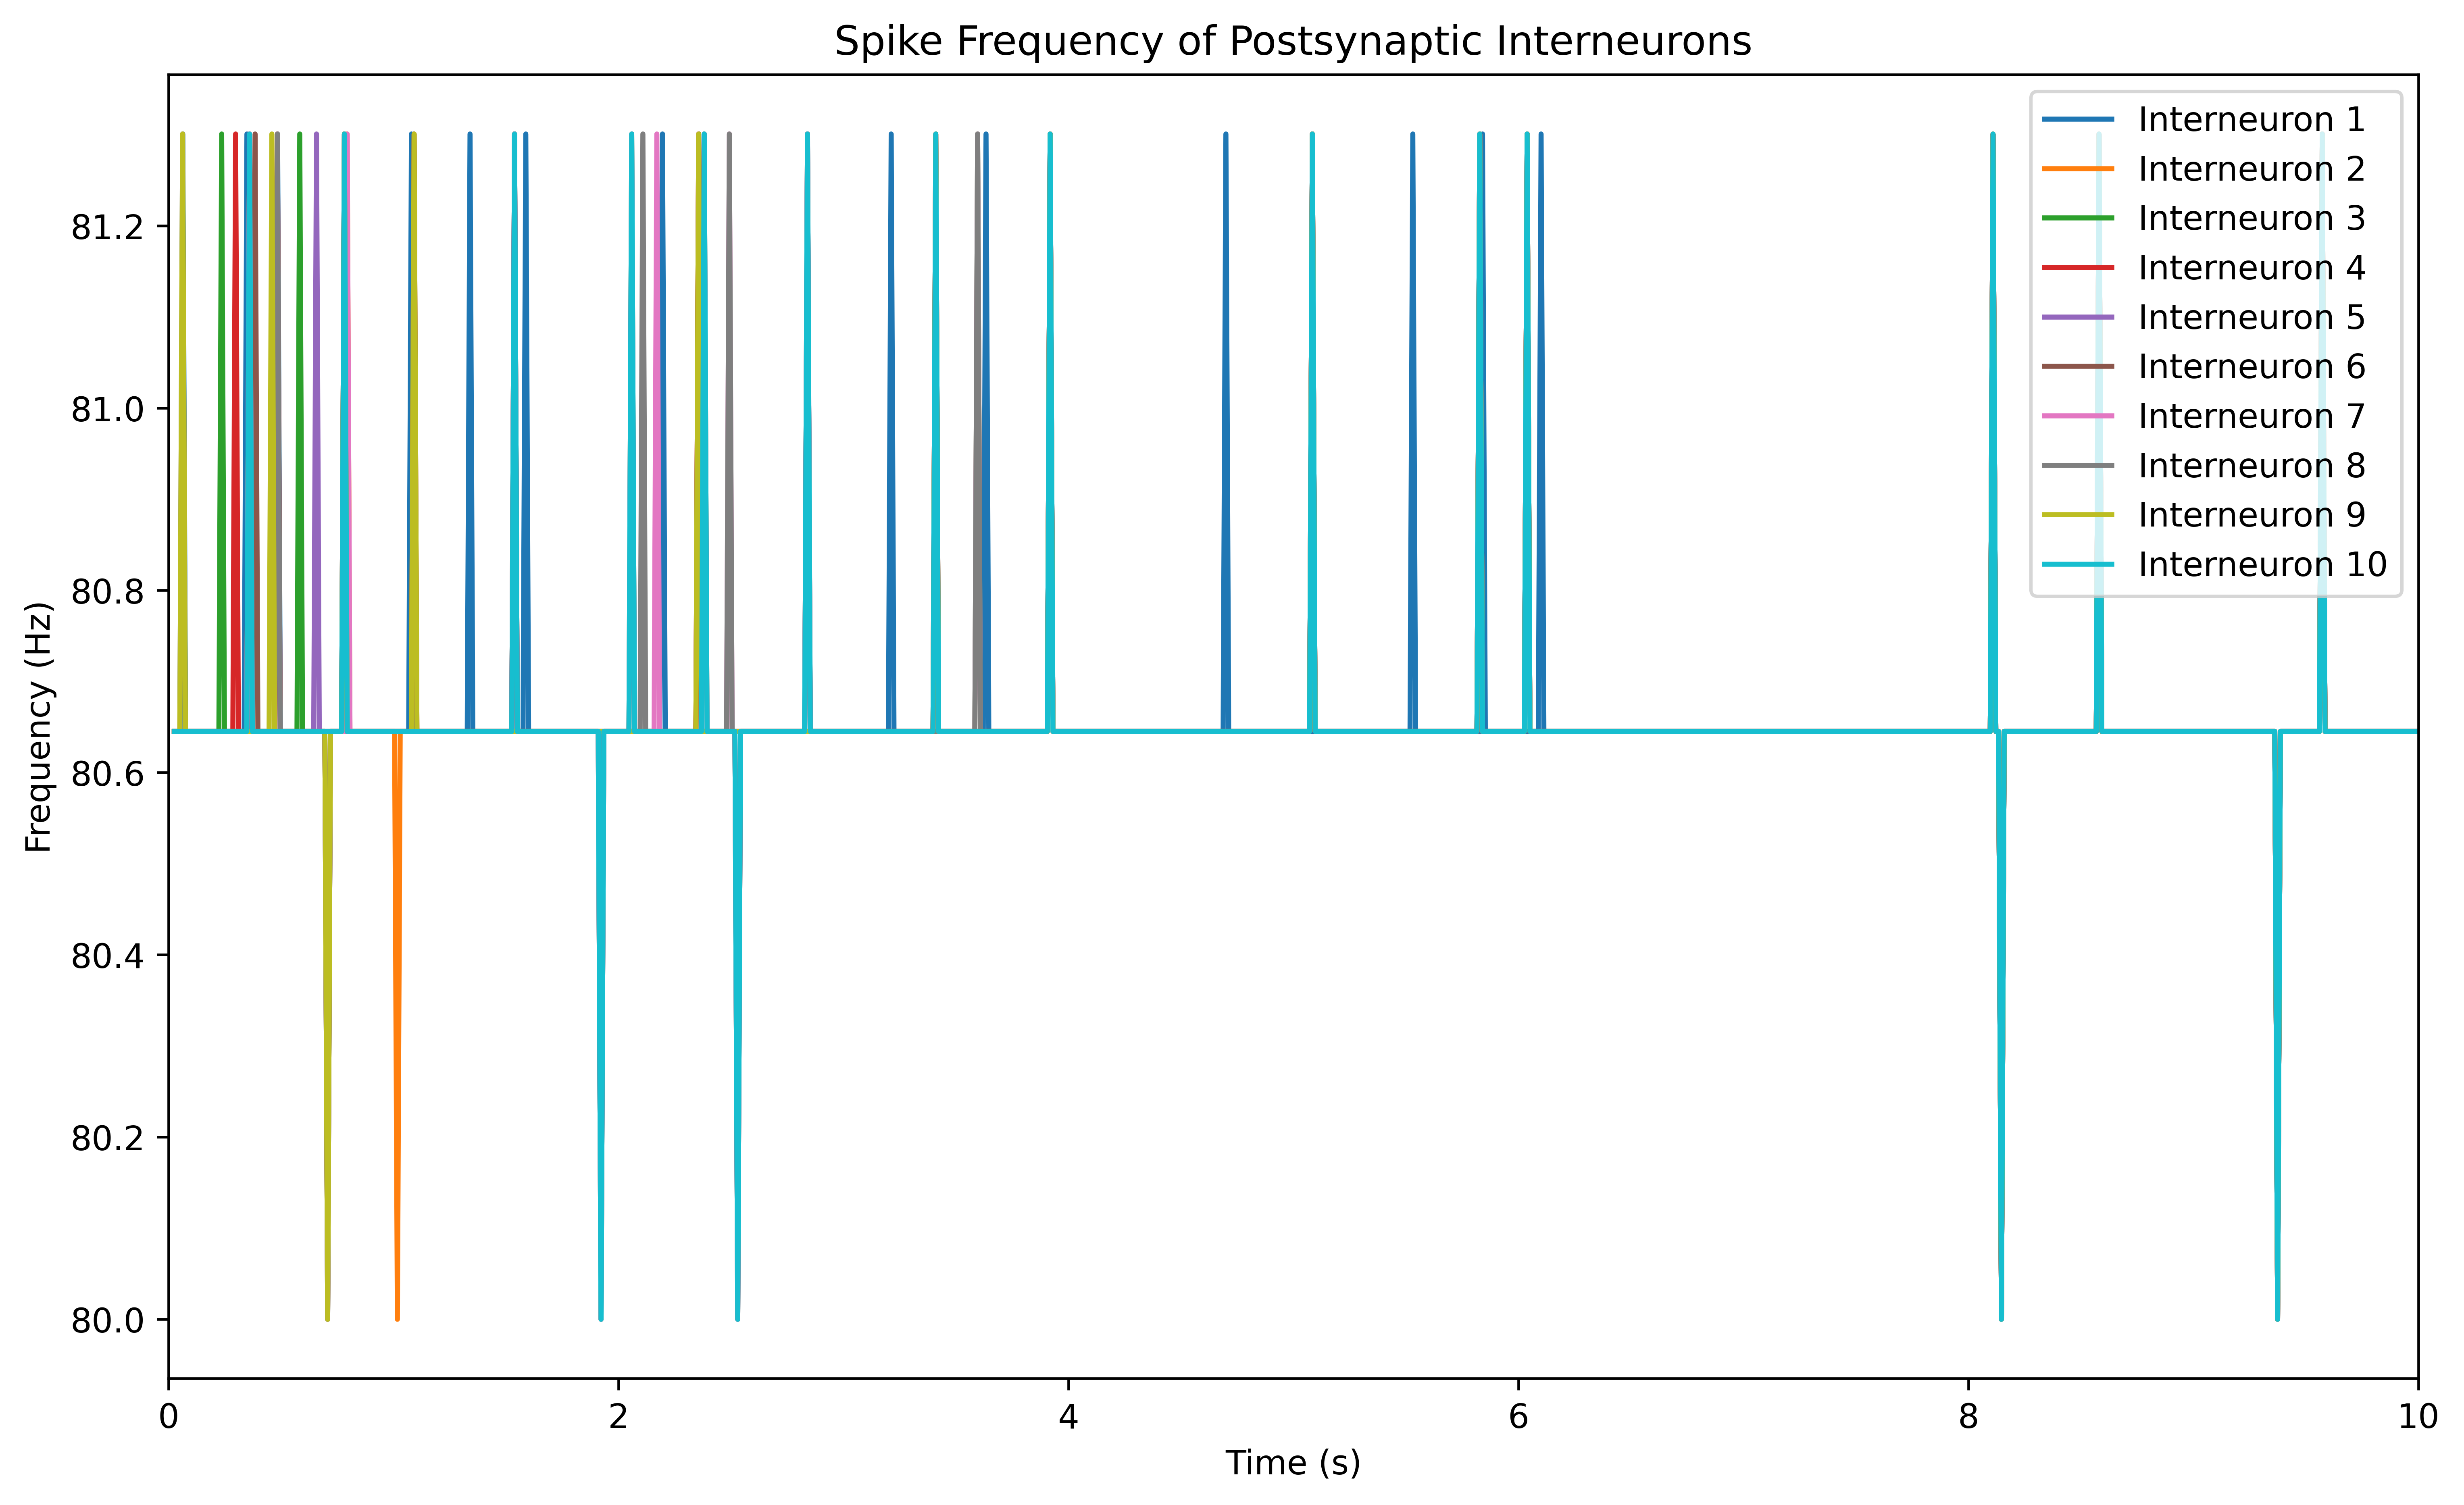

In [348]:

plt.figure(figsize=[12, 7])
for i in range(net.get_num_outputs_actual()):
    freq, loc = getFreq(data=stdp_data[i,:], dt=sns_dt)
    # print(np.mean(freq))
    plt.plot(loc/1000, freq, label=('Interneuron ' + str(i + 1)))
plt.ylim()
if x_zoom is not None:
    plt.xlim(x_zoom)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spike Frequency of Postsynaptic Interneurons')
plt.legend(loc='upper right')
plt.savefig('C:/Users/markpup/Desktop/SNS Figures/LivingMachines Images/PresentationPhotos/postfreq.png', dpi=600)
plt.show()

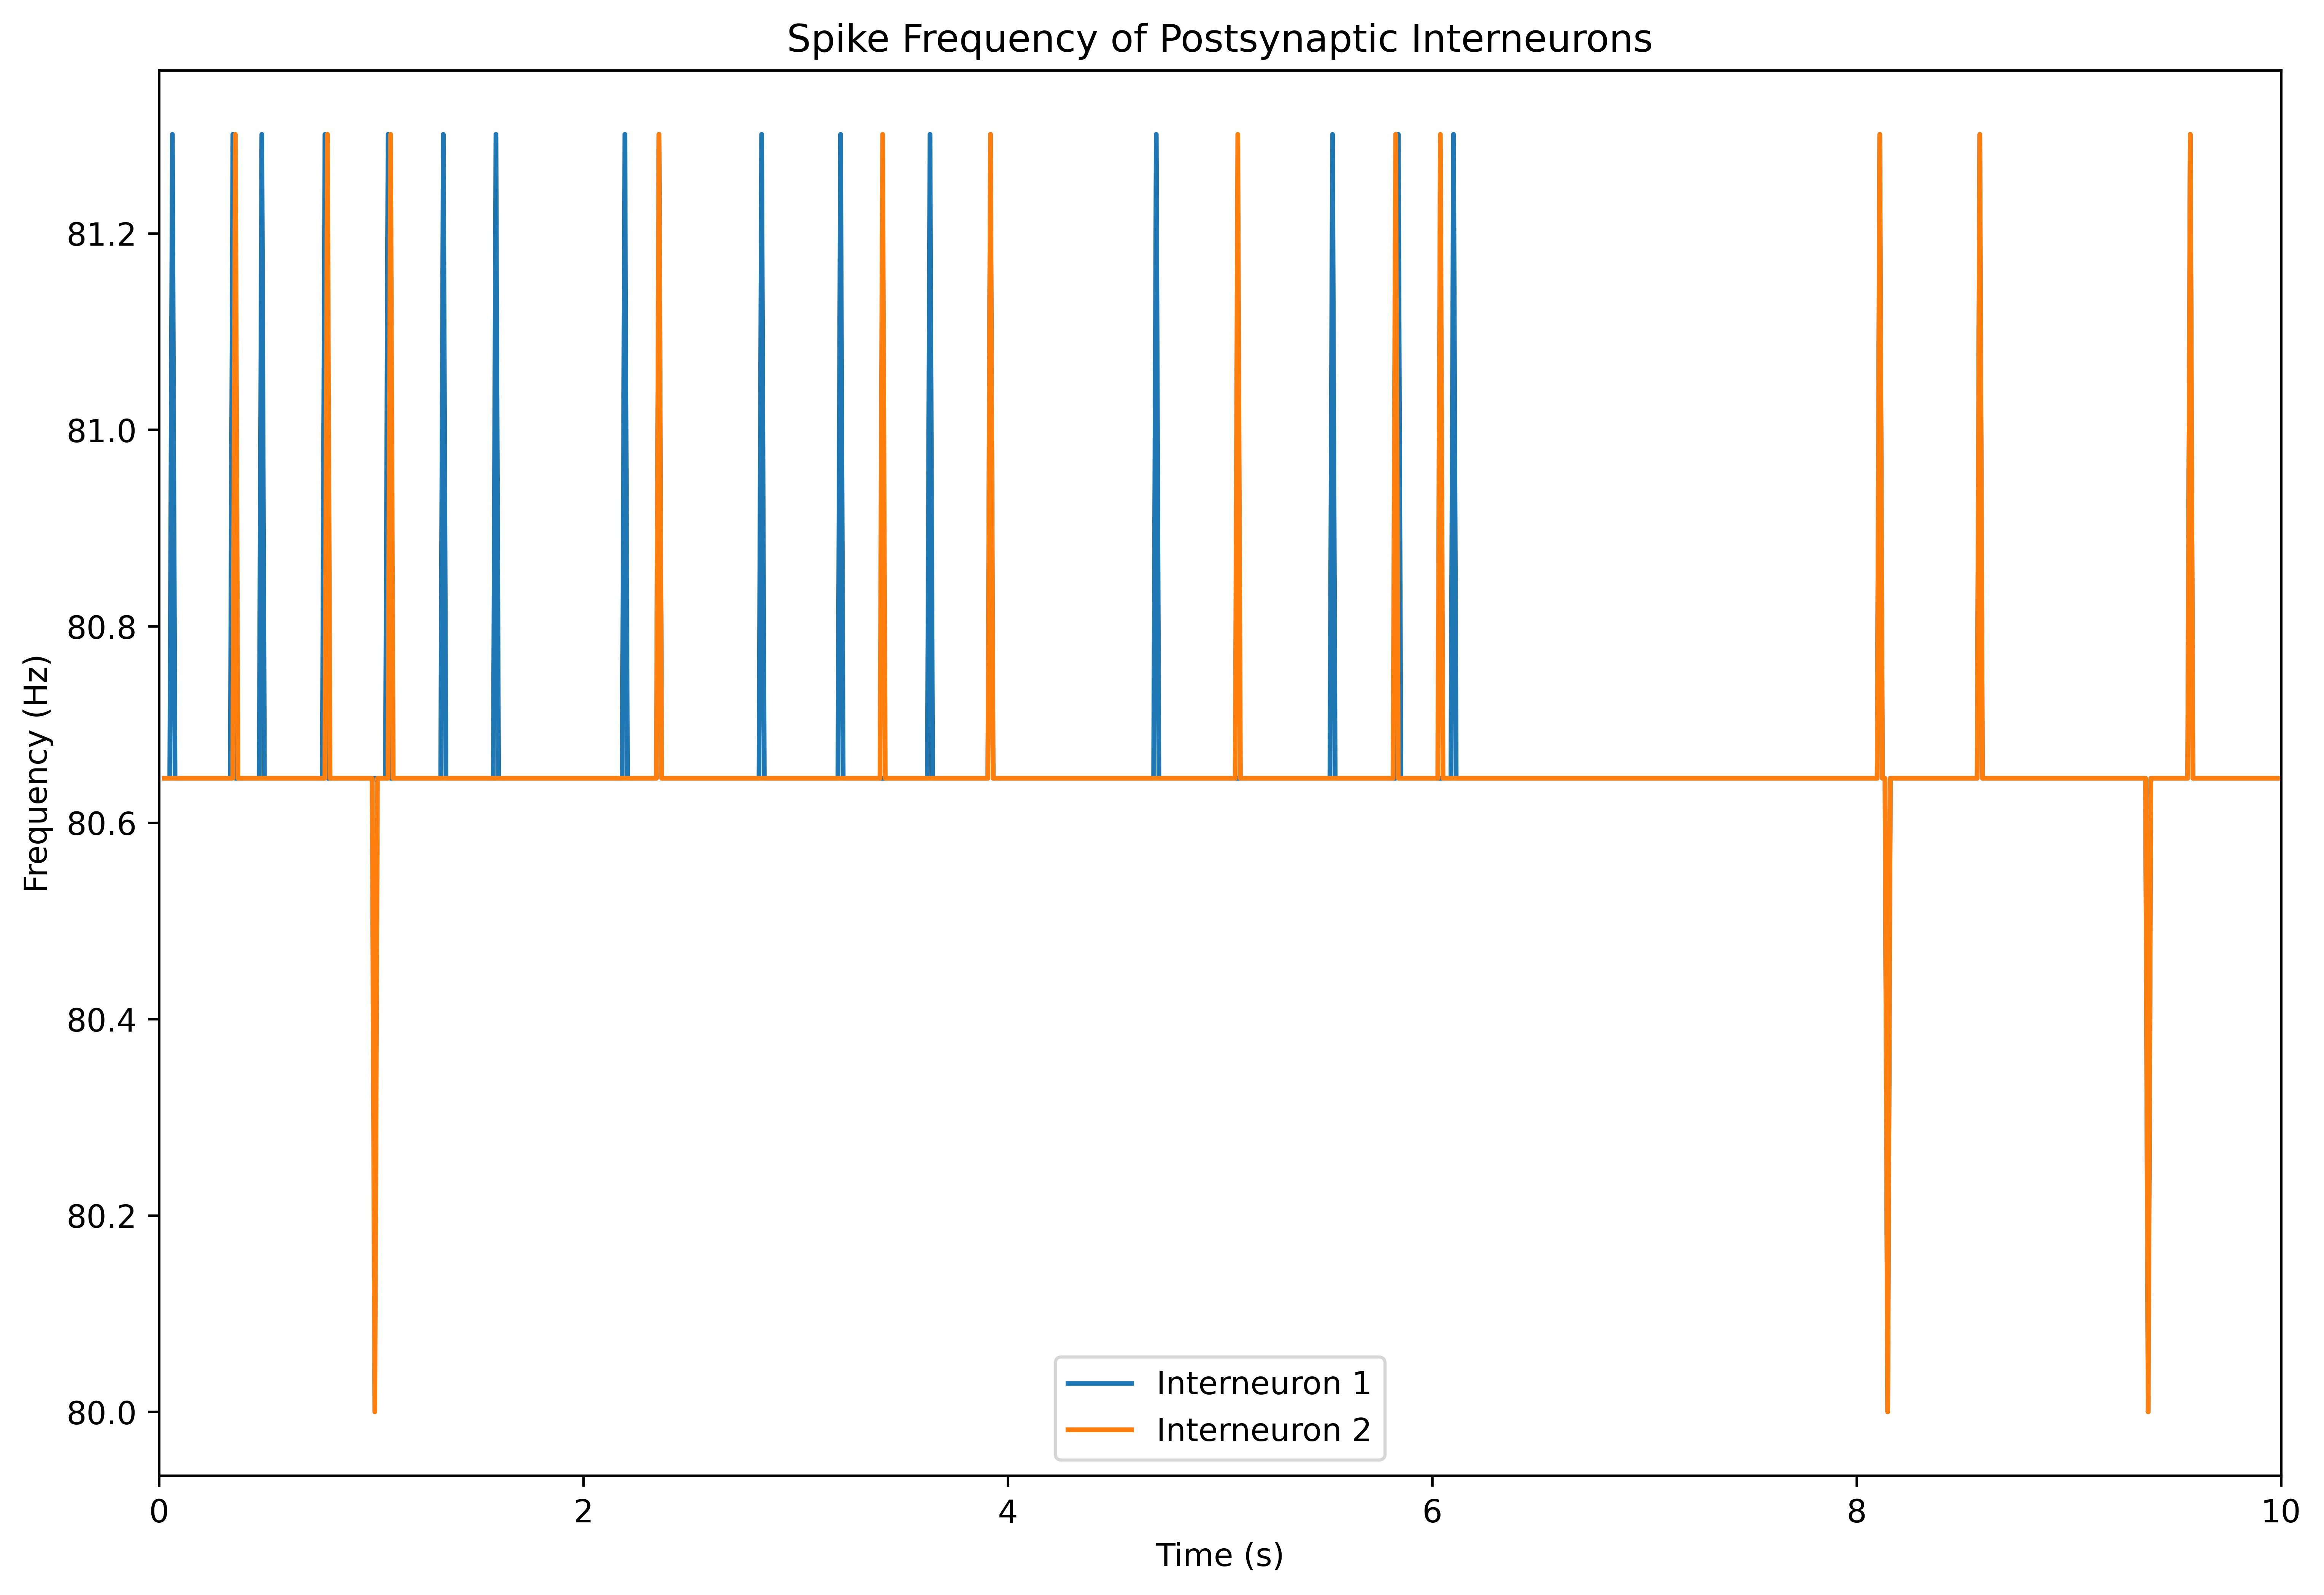

In [349]:

# Plotting just interneuron 1 and 2 for presentation
plt.figure(figsize=[12, 8])
for i in range(2):
    freq, loc = getFreq(data=stdp_data[i,:], dt=sns_dt)
    # print(np.mean(freq))
    plt.plot(loc/1000, freq, label=('Interneuron ' + str(i + 1)))
plt.ylim()
if x_zoom is not None:
    plt.xlim(x_zoom)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Spike Frequency of Postsynaptic Interneurons')
plt.legend()
plt.savefig('C:/Users/markpup/Desktop/SNS Figures/LivingMachines Images/PresentationPhotos/postfreq_cut.png', dpi=600)
plt.show()

In [350]:
# print(sns_stdp_network.__dict__.get('g_max_spike'))
# print(sns_stdp_network.__dict__.get('g_increment'))

print('Initial syanptic conductance')
print(initial_conductance)

print('Final synaptic conductance')
print(sns_stdp_network.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM])

print('Change in synaptic conductance:')
print(sns_stdp_network.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM] - initial_conductance)

Initial syanptic conductance
[[3.48 1.68 3.37 3.24]
 [3.08 1.52 1.6  2.8 ]
 [3.26 3.99 2.68 2.08]
 [3.72 2.2  3.17 2.52]
 [1.72 3.18 2.59 3.57]
 [3.52 3.83 3.66 2.92]
 [3.9  2.57 3.14 1.77]
 [3.85 3.09 3.94 1.77]
 [2.47 3.75 2.23 3.82]
 [1.82 2.37 2.91 3.99]]
Final synaptic conductance
[[4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]
 [4.         4.         2.78043002 4.        ]]
Change in synaptic conductance:
[[ 0.52        2.32       -0.58956998  0.76      ]
 [ 0.92        2.48        1.18043002  1.2       ]
 [ 0.74        0.01        0.10043002  1.92      ]
 [ 0.28        1.8        -0.38956998  1.48      ]
 [ 2.2

Simple results analysis

In [351]:

# Analyze the results. Compare the conductance values for one pair against the other
# Look at each postsynaptic neuron's connection to the set of 4 pre's
for post in sns_stdp_network.g_max_spike[STDP_PRE_NUM:, 0:STDP_PRE_NUM]:
    # Check the connection pairs
    if post[0] > 3.5 and post[1] > 3.5:
        if post[2] < 2.0 and post[3] < 2.0:
            print('Neuron Organizing Success: Connected to pair 1')
        else:
            print('Neuron Organizing Fail')
    elif post[2] > 3.5 and post[3] > 3.5:
        if post[0] < 2.0 and post[1] < 2.0:
            print('Neuron Organizing Success: Connected to pair 2')
        else:
            print('Neuron Organizing Fail')
    else:
        print('Neuron Organizing Failure')

Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail
Neuron Organizing Fail


Conductance History

In [352]:

conductance_timestep = 10

plt.figure(figsize=[12, STDP_POST_NUM * 3])

for post in range(STDP_POST_NUM):
    plt.subplot(STDP_POST_NUM, 1, post + 1)
    plt.title('↓ Postsynaptic Interneuron ' + str(post + 1) + ' ↓')
    for pre in range(STDP_PRE_NUM):
        plt.plot(mj_t[::conductance_timestep], g_track[::conductance_timestep, post, pre], label=('Sensory Neuron ' + str(pre + 1)))
    plt.ylim([0, max_condutance+1])
    if x_zoom is not None:
        plt.xlim(x_zoom)
    plt.ylabel('Conductance (uS)')
    if post == 9:
        plt.xlabel('Time (s)')
    plt.legend(loc='lower right')
plt.subplots_adjust(hspace=0.5)
plt.savefig('C:/Users/markpup/Desktop/SNS Figures/LivingMachines Images/PresentationPhotos/conductance.png', dpi=600)
plt.show()

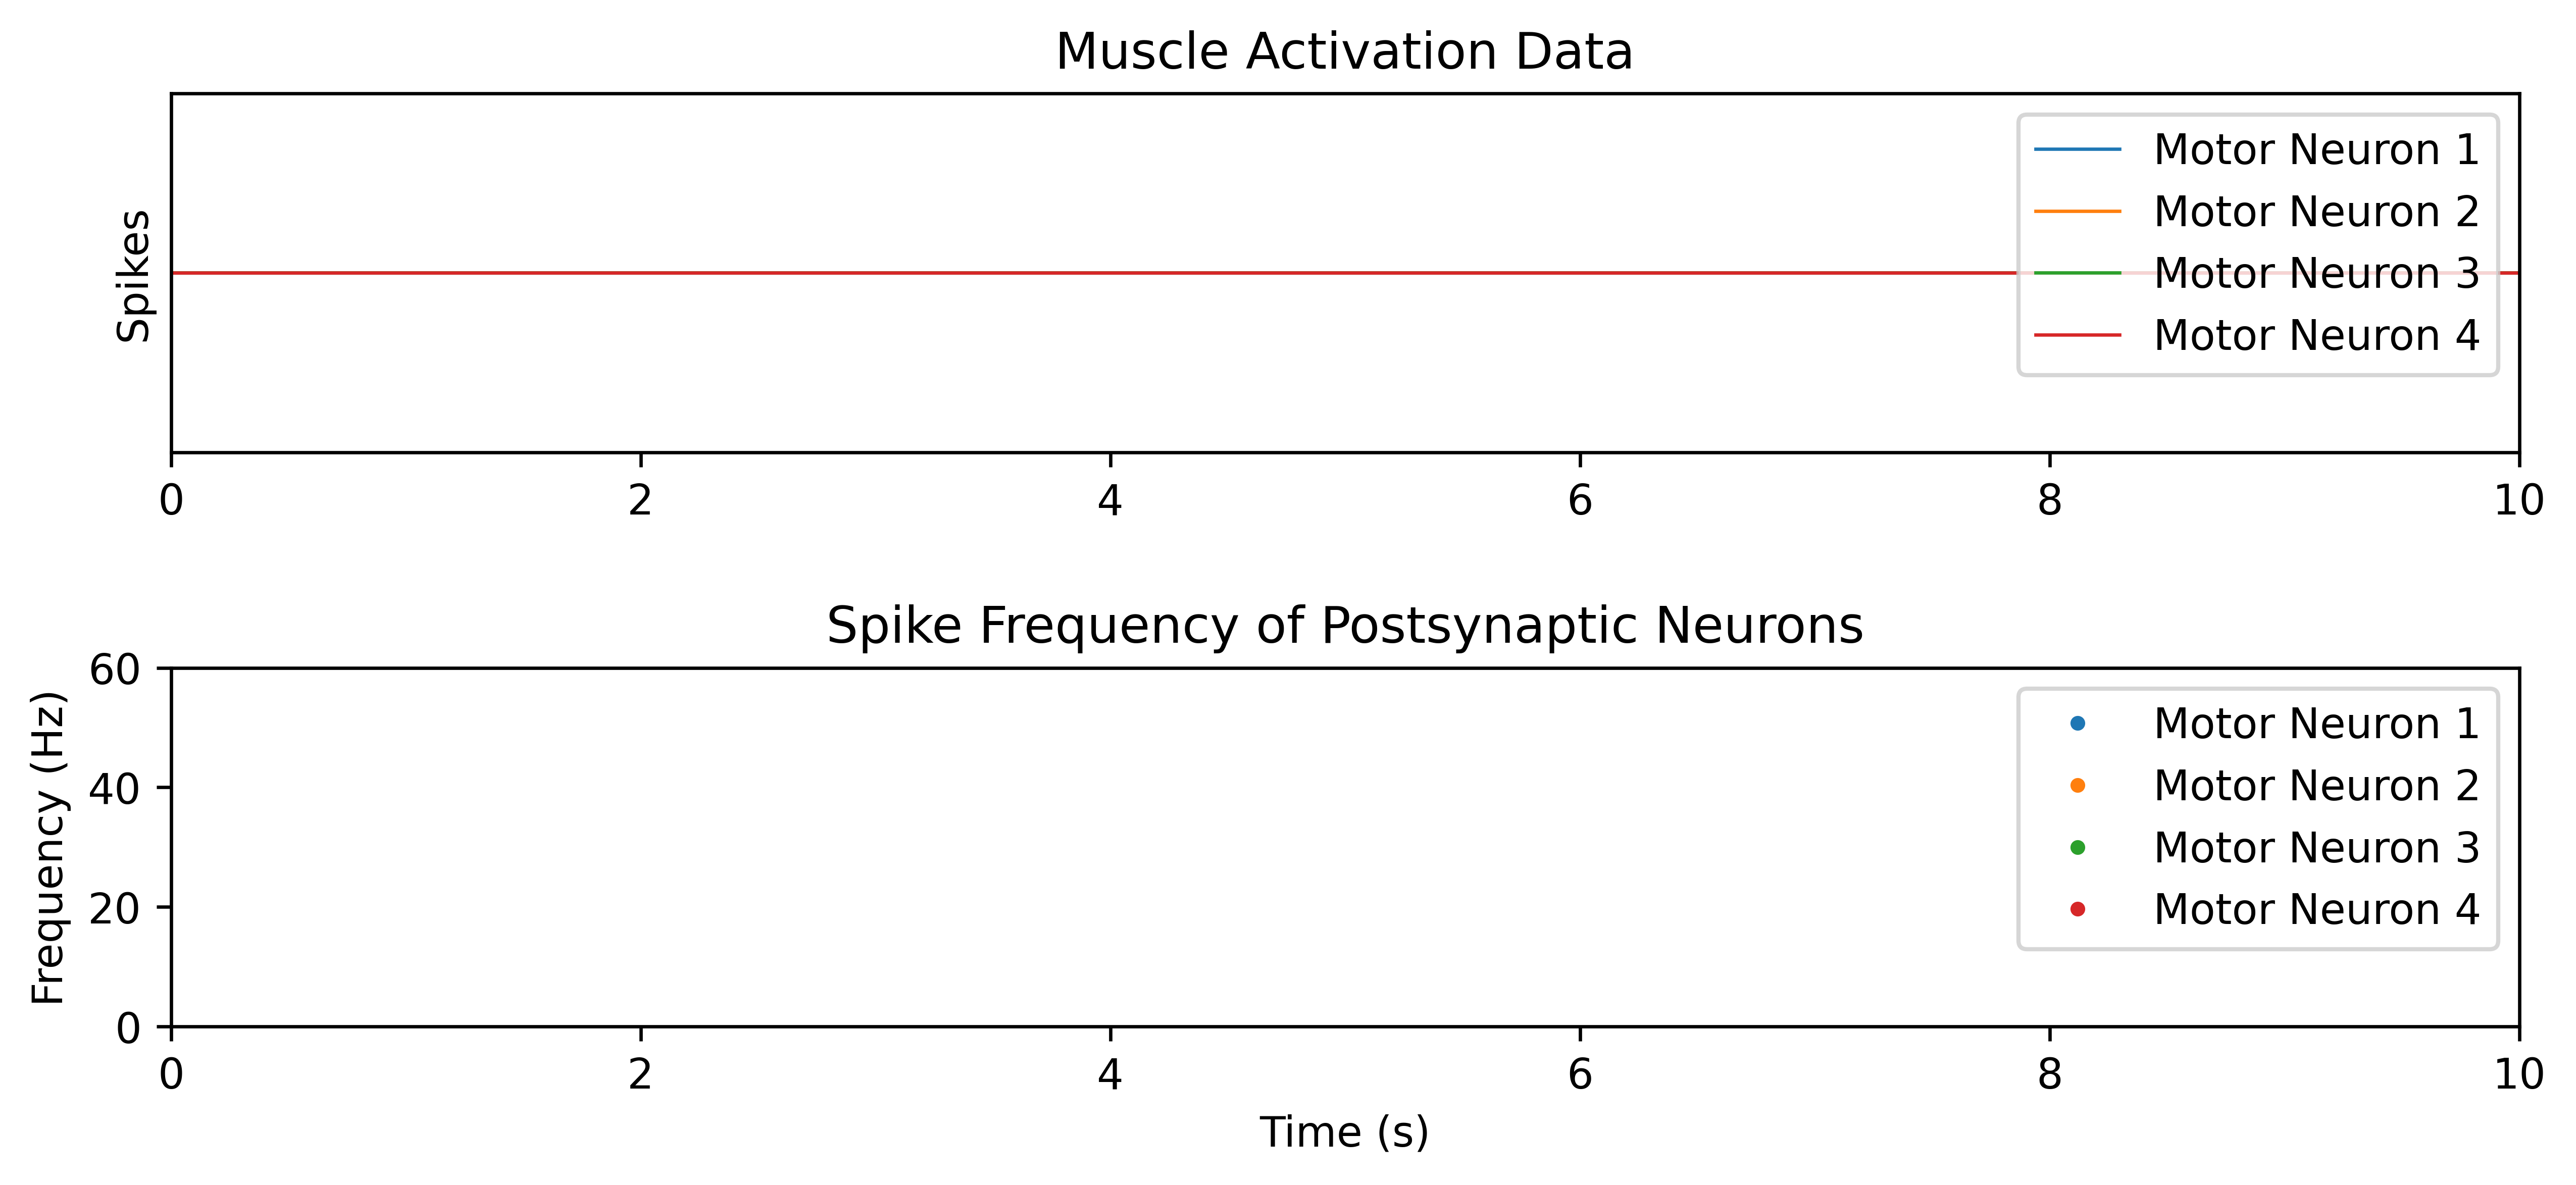

In [353]:

# Plot motor neuron data if needed
plt.figure(figsize=[10, 4])
plt.subplot(2, 1, 1)

for mn in range(MJ_MUSCLE_NUM):
    plt.plot(mj_t[::1], mn_data[mn,::1] * (0.1*(10-mn)), label=('Motor Neuron ' + str(mn + 1)), linewidth=0.8)
plt.title('Muscle Activation Data')
plt.ylabel('Spikes')
plt.yticks(ticks=[])
# plt.xlabel('Time (s)')
plt.xlim([-mj_tmax*0.04, mj_tmax*1.04])
if x_zoom is not None:
    plt.xlim(x_zoom)
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
for mn in range(MJ_MUSCLE_NUM):
    freq, loc = getFreq(data=mn_data[mn,:], dt=sns_dt)
    freq = np.asarray(freq)
    loc = np.asarray(loc)
    # Create logic mask of True/False for the different values in the array
    mask = freq >= 10
    # Slice the two arrays, cutting out both freq and loc values
    freq = freq[mask]
    loc = loc[mask]
    # Plot this motor neuron's data
    plt.plot(loc/1000, freq, '.', label=('Motor Neuron ' + str(mn + 1)), markersize=5)
plt.ylim(0, 60)
plt.ylabel('Frequency (Hz)')
plt.xlim([-mj_tmax*0.04, mj_tmax*1.04])
if x_zoom is not None:
    plt.xlim(x_zoom)
plt.xlabel('Time (s)')
plt.title('Spike Frequency of Postsynaptic Neurons')
plt.legend(loc='upper right')

plt.savefig('C:/Users/markpup/Desktop/SNS Figures/LivingMachines Images/PresentationPhotos/mndata.png', dpi=600)

plt.subplots_adjust(hspace=0.6)
plt.show()

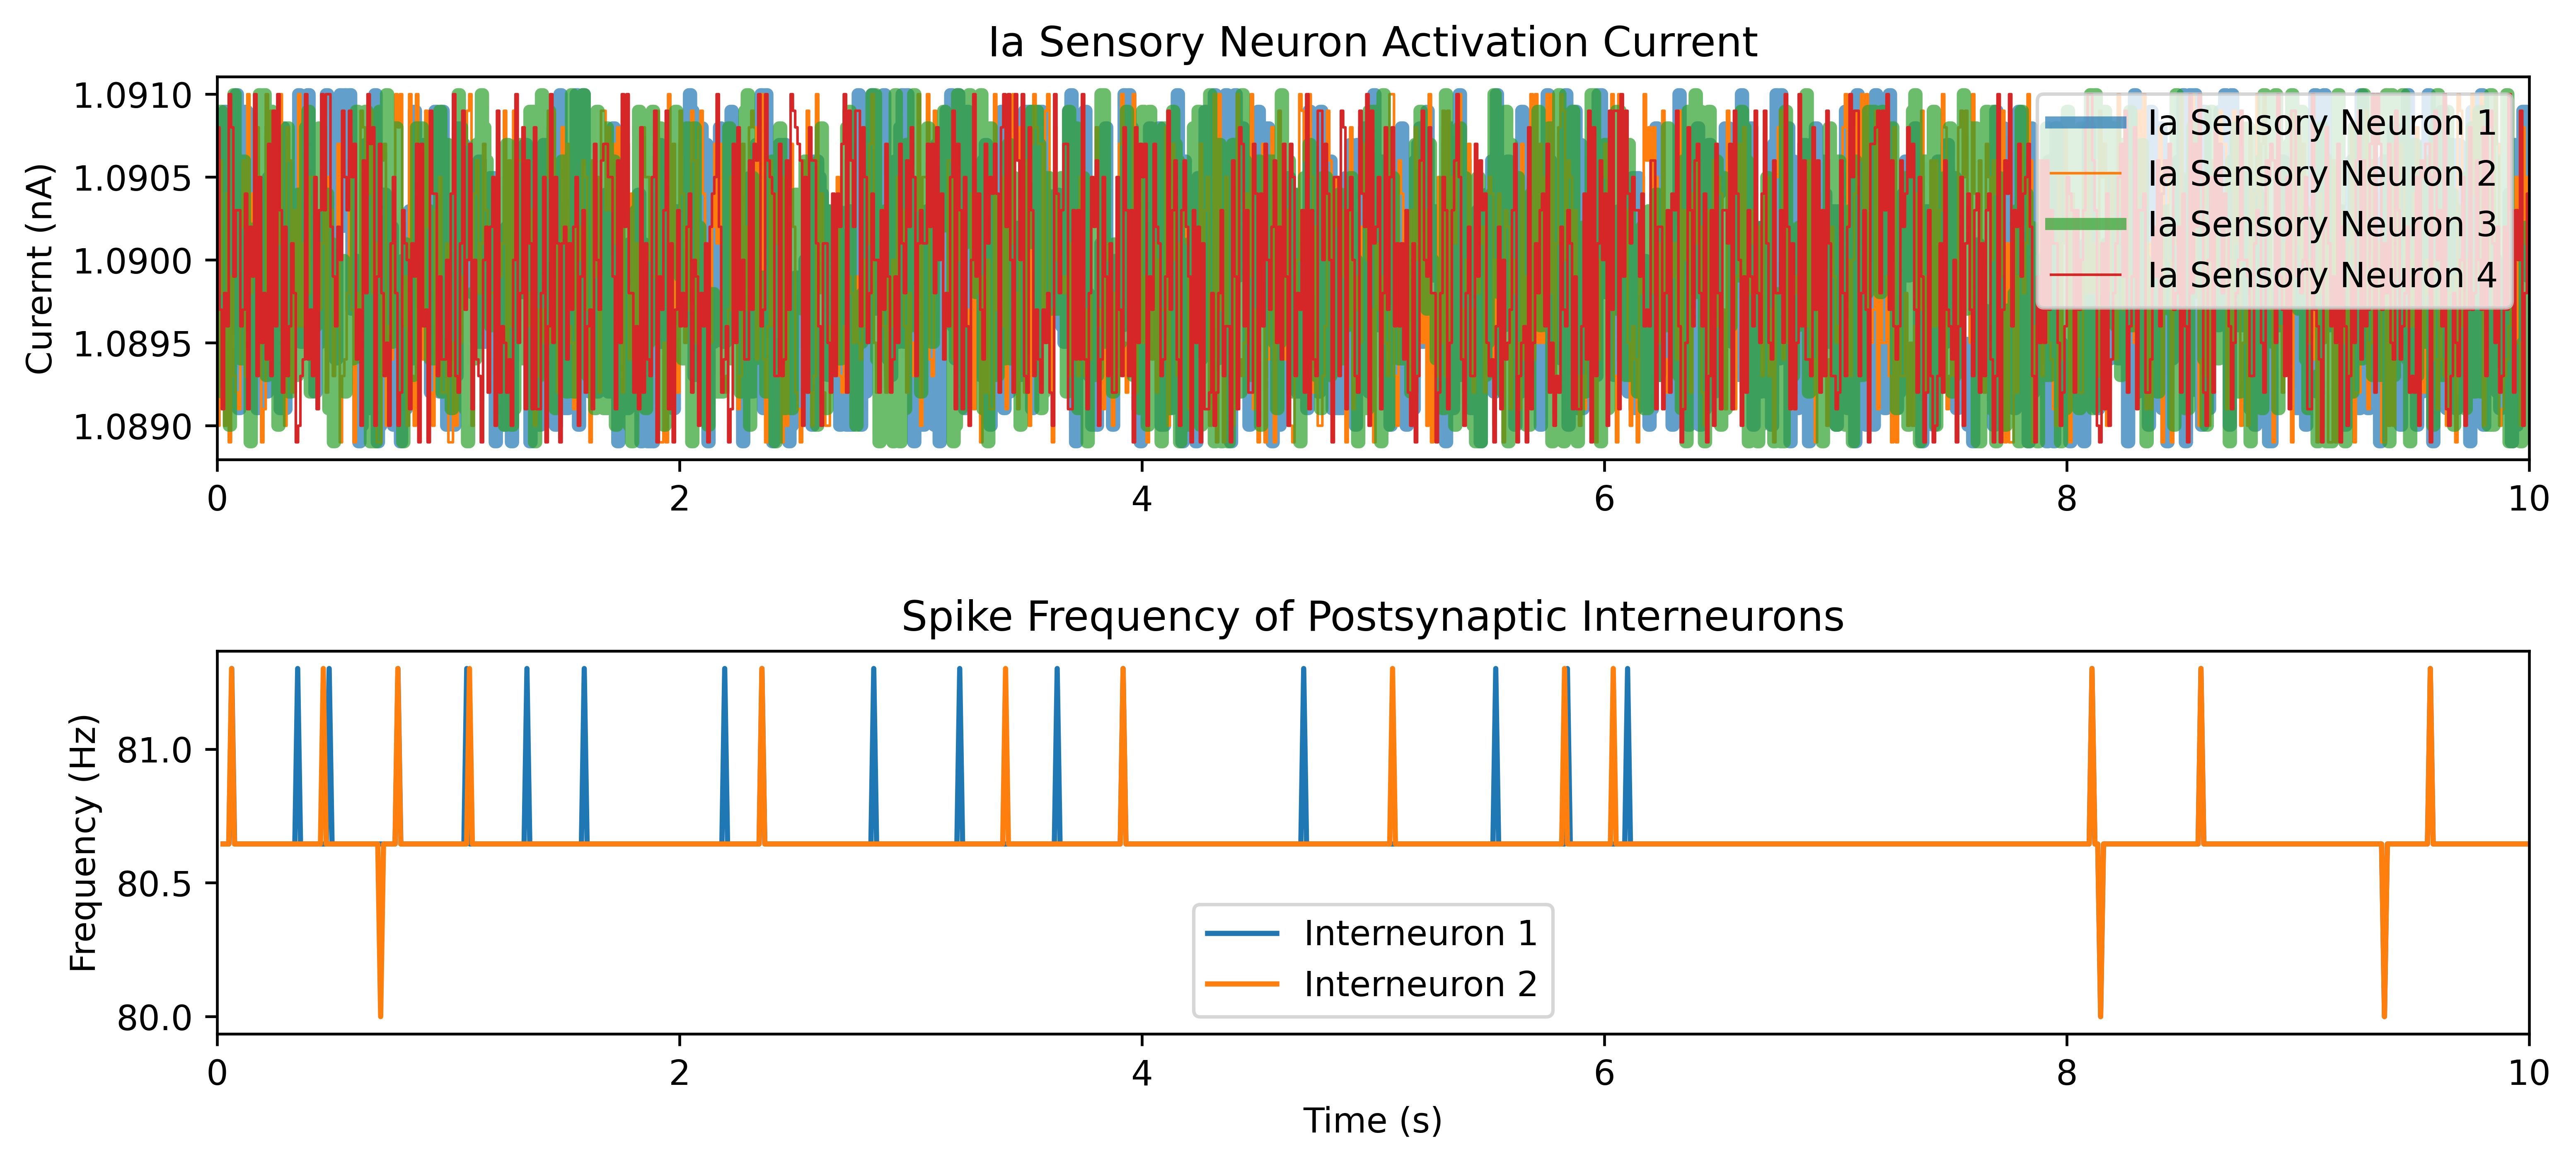

In [354]:
def plot_just2():
    plt.figure(figsize=[12, 5])
    plt.subplot(2, 1, 1)
    for i in range(MJ_MUSCLE_NUM):
        if i % 2 == 0:
            plt.plot(mj_t[::mj_timestep], stdp_activation_current[i,::mj_timestep], label=('Ia Sensory Neuron ' + str(i + 1)), linewidth=3.5, alpha=0.7)
        else:
            plt.plot(mj_t[::mj_timestep], stdp_activation_current[i,::mj_timestep], label=('Ia Sensory Neuron ' + str(i + 1)), linewidth=0.75, alpha=1.0)
    plt.title(mj_title + 'Ia Sensory Neuron Activation Current' + mj_title)
    plt.legend(loc='upper right')
    plt.ylabel('Curernt (nA)')
    # plt.xlabel('Time (s)')
    if x_zoom is not None:
        plt.xlim(x_zoom)
    plt.subplots_adjust(hspace=0.5)

    plot_only = [0, 8]
    j = 1

    plt.subplot(2, 1, 2)
    for i in plot_only:
        freq, loc = getFreq(data=stdp_data[i,:], dt=sns_dt)
        # print(np.mean(freq))
        plt.plot(loc/1000, freq, label=('Interneuron ' + str(j)))
        j=j+1
    plt.ylim()
    if x_zoom is not None:
        plt.xlim(x_zoom)
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title('Spike Frequency of Postsynaptic Interneurons')
    plt.legend()
    plt.show()

plot_just2()


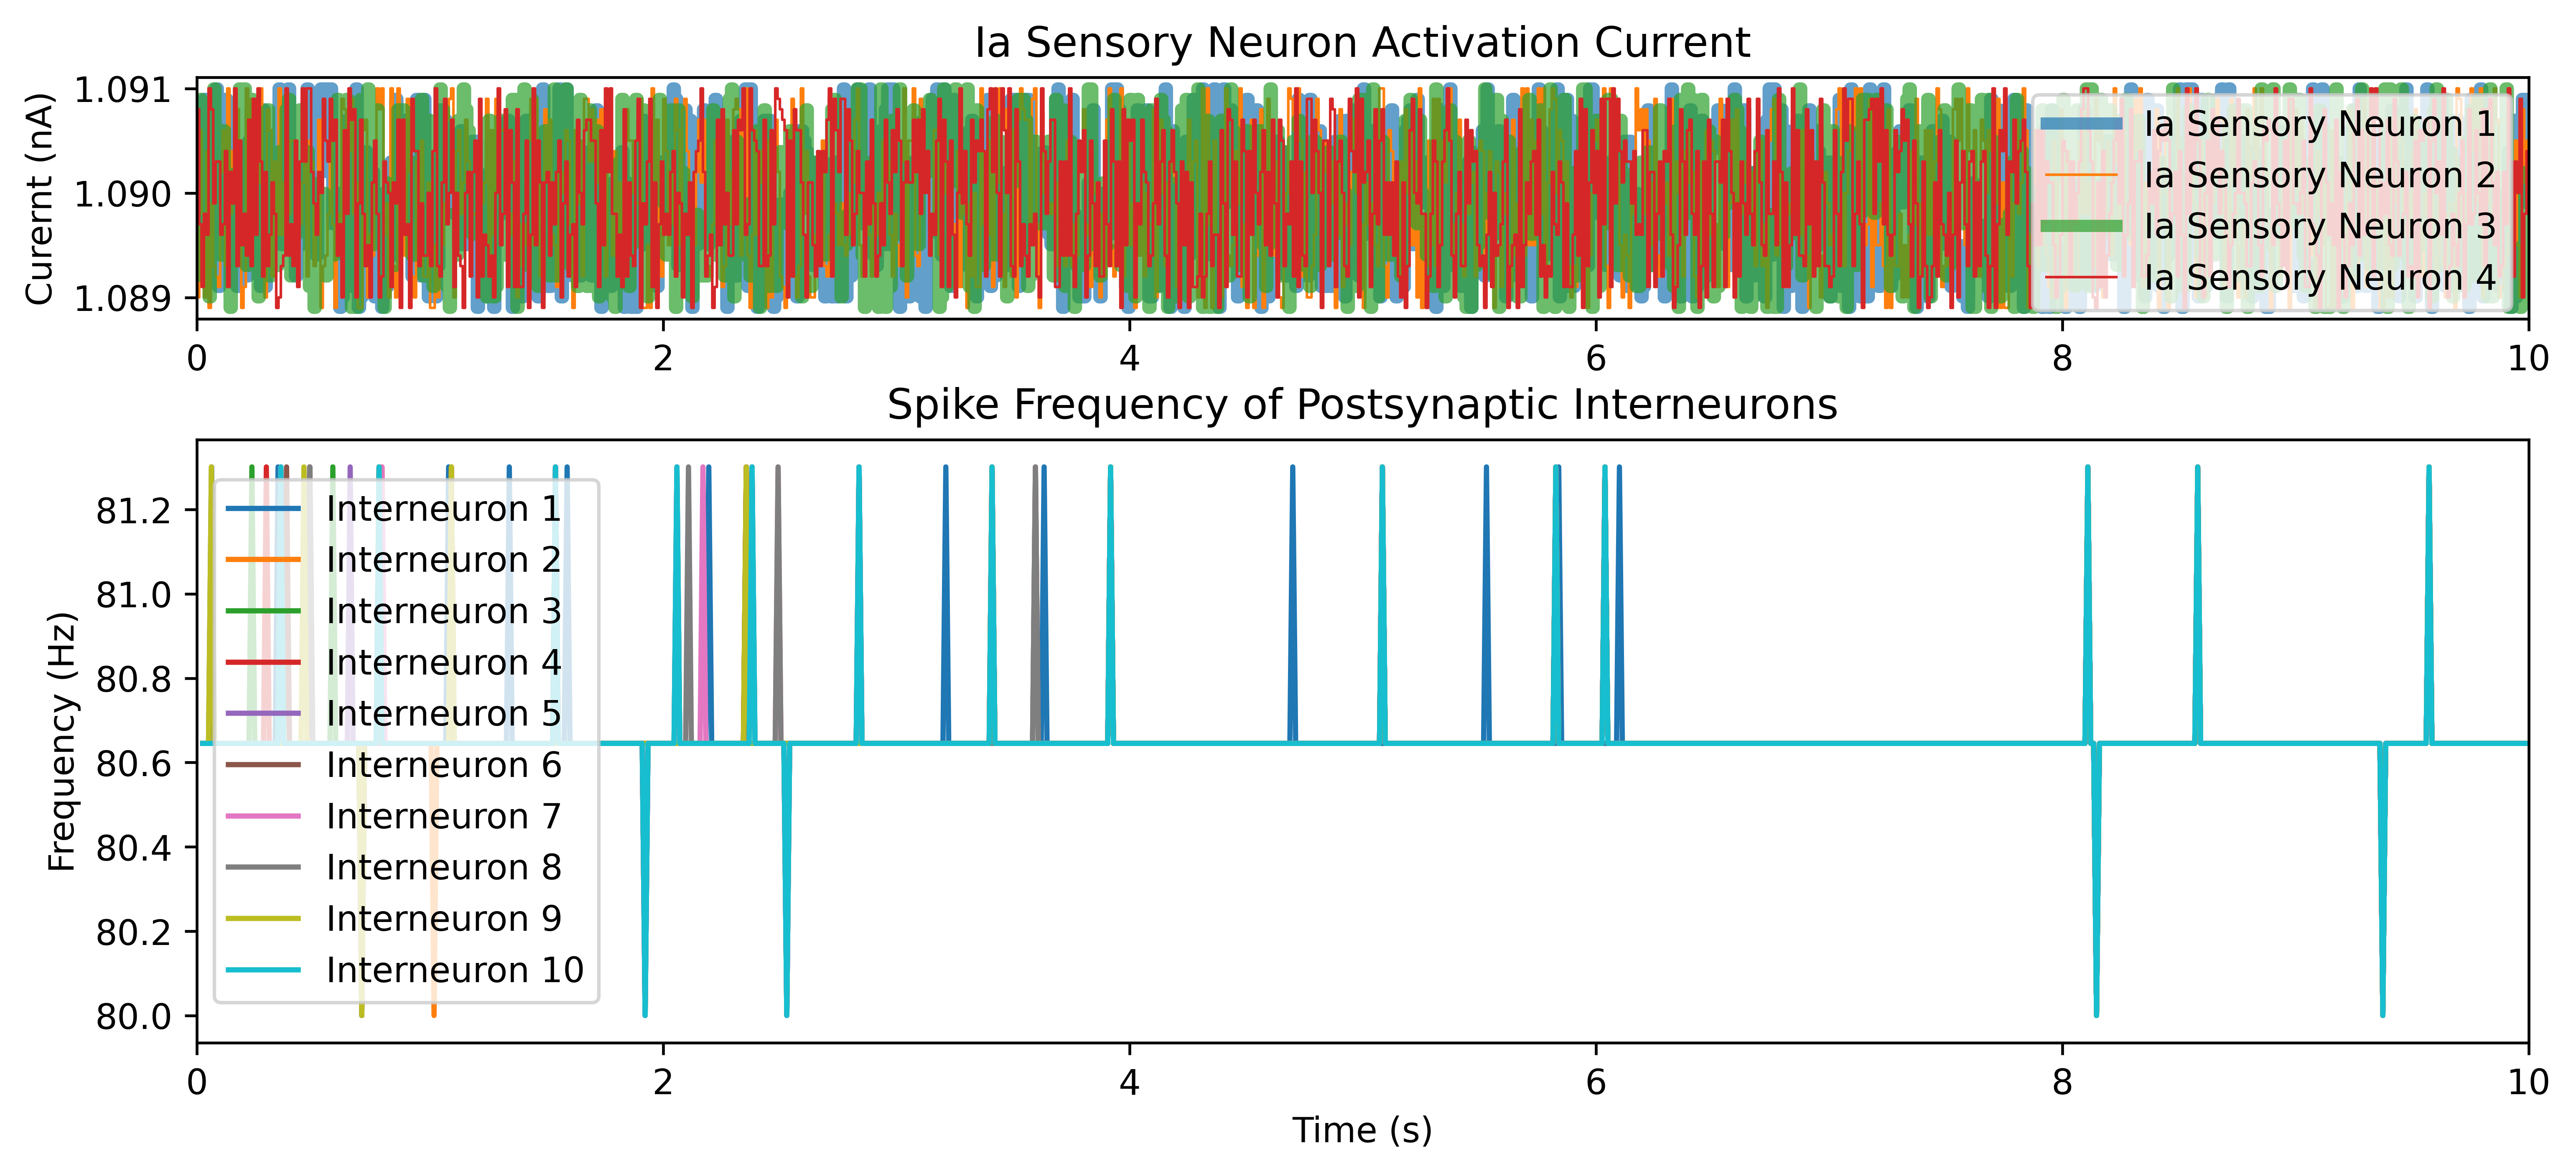

In [355]:
def plot_all10():
    fig = plt.figure(figsize=[12, 5])
    gs = GridSpec(nrows=3, ncols=1, figure=fig)

    plt1 = fig.add_subplot(gs[0, 0])
    plt2 = fig.add_subplot(gs[1:, 0])
    plt.subplots_adjust(hspace=0.5)

    for i in range(MJ_MUSCLE_NUM):
        if i % 2 == 0:
            plt1.plot(mj_t[::mj_timestep], stdp_activation_current[i,::mj_timestep], label=('Ia Sensory Neuron ' + str(i + 1)), linewidth=3.5, alpha=0.7)
        else:
            plt1.plot(mj_t[::mj_timestep], stdp_activation_current[i,::mj_timestep], label=('Ia Sensory Neuron ' + str(i + 1)), linewidth=0.75, alpha=1.0)
    plt1.set_title(mj_title + 'Ia Sensory Neuron Activation Current' + mj_title)
    plt1.legend(loc='upper right')
    plt1.set_ylabel('Curernt (nA)')
    # plt.xlabel('Time (s)')
    if x_zoom is not None:
        plt1.set_xlim(x_zoom)

    for i in range(10):
        freq, loc = getFreq(data=stdp_data[i,:], dt=sns_dt)
        # print(np.mean(freq))
        plt2.plot(loc/1000, freq, label=('Interneuron ' + str(i + 1)))
    plt2.set_ylim()
    if x_zoom is not None:
        plt2.set_xlim(x_zoom)
    plt2.set_ylabel('Frequency (Hz)')
    plt2.set_xlabel('Time (s)')
    plt2.set_title('Spike Frequency of Postsynaptic Interneurons')
    plt2.legend()

    plt.show()

plot_all10()